In [1]:
# os, glob 경로나 파일 os 명령
import os 
from glob import glob

# PIL는 이미지를 load 할 때, numpy는 array 
from PIL import Image
import numpy as np

# 이미지 볼 때 
import matplotlib.pyplot as plt
# 아래에 magic function은 jupyter notebook에만 해당됩니다. 
# 이건 jupyter로 열면, 주피터 내부 열수 있게 하는 것 
% matplotlib inline

### 준비하기  
데이터를 준비 할 때 저는 tensorflow나 다른데에서 예제로 제공해주는 그런 데이터 말고  
png나 우리가 커스텀으로 다룰 데이터를 학습 모델에 input으로 넣을 파일을 만들겁니다. 

먼저 아래의 kaggle에서 데이터들 부터 다운 받자  
https://www.kaggle.com/scolianni/mnistasjpg/data  

![dir_tree_mnist](../assets/post_images/dir_tree_mnist.png)

Kaggle에서 저 링크로 다운 받으면 mnistasjpg.zip 라는 파일을 받고 압축을 푼다.  
압축을 풀고나면 그 안에 trainingSet.tar.gz 까지 풀어준다.  
그럼 압축 푼 파일을 먼저 이 jupyter notebook 파일 또는 py 파일이랑 같은 경로에 'data/'라는 폴더를 만들어서 안에 넣는다.  

정리하자면 아래와 같다  

![mnist_download](../assets/post_images/mnist_download.png)

그 안에 mnist_png 파일을 

# 이미지 경로들 부르고, Label 얻기  

이미지 데이터들이 저장된 파일 목록들을 불러와 경로들을 List로 저장하고  
각 경로들을 통해 Label(Class)를 얻는다. 

In [2]:
os.listdir()  # 같은 경로 레벨에 있는 파일들의 목록을 보여준다. 

['.ipynb_checkpoints', '2018-05-12-input_data 만들기.ipynb']

In [4]:
os.listdir('data/')  # 해당 경로 안에서의 폴더 목록을 list로 반환

['mnist_png', 'mnist_png.rar', 'train', 'train.7z', 'trainLabels.csv']

In [5]:
data_list = glob('data\\mnist_png\\training\\*\\*.png')  # 모든 경로들을 list로 반환

In [6]:
# 여기서 path를 하나 뽑고서 이것으로 이미지를 불러오고, Label도 불러올 것이다. 
path = data_list[0]
path

'data\\mnist_png\\training\\0\\1.png'

In [7]:
def get_label_from_path(path):
    return int(path.split('\\')[-2])

In [8]:
path, get_label_from_path(path)  # 제대로 뽑아졌는지 확인 

('data\\mnist_png\\training\\0\\1.png', 0)

다시 제대로 뽑아지는지 랜덤하게 넣어서 확인 해보자

In [9]:
rand_n = 9999  # <- 아무 숫자나 넣은 거다 

path = data_list[rand_n]
path, get_label_from_path(path)  # 제대로 뽑아졌는지 확인 

('data\\mnist_png\\training\\1\\42015.png', 1)

## 이미지 불러오기 & Label - onehot-encoding 불러오기
여기까지는 경로와 Label 이름을 뽑는 것이 제대로 확인이 되었다.  
이제부터 그 경로와 Label명을 통해 one-encoding을 만들것이다. 

In [10]:
# path로 부터 Image 불러오기
image = np.array(Image.open(path))

In [11]:
def read_image(path):
    image = np.array(Image.open(path))
    # Channel 1을 살려주기 위해 reshape 해줌
    return image.reshape(image.shape[0], image.shape[1], 1)

In [12]:
# label 이름을 통해 onehot-encoding 하기 
class_name = get_label_from_path(path)

In [13]:
# 앞서 만들었던 get_label_from_path 함수를 통해 data_list에 있는 label 이름들을 list에 다 묶어준다
# 더 쉬운 방법이 있지만, 굳이 함수를 통해 label 들을 얻는 것은 함수도 잘 작동하는지 확인함을 목적을 가지고 있다. 

label_name_list = []
for path in data_list:
    label_name_list.append(get_label_from_path(path))

In [14]:
unique_label_names = np.unique(label_name_list)
unique_label_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
def onehot_encode_label(path):
    onehot_label = unique_label_names == get_label_from_path(path)
    onehot_label = onehot_label.astype(np.uint8)
    return onehot_label

In [16]:
onehot_encode_label(path)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [17]:
# 이미지 읽고(array로 열면 너무 크기 때문에 여기선 shape로 확인), onehot_label 확인
read_image(path).shape, onehot_encode_label(path)

((28, 28, 1), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8))

## Batch Data 만들기  
앞에 Image를 부르고, onehot_enocding도 했으니 이걸로 batch 만들기  

방법.1  
- Empty Array 를 만들고 그 Array에 이미지 한장 한장 채운다 

방법. 2  
- 이미지 한장 한장씩 Batch Size 만큼 붙여 간다 (concatenation)

In [21]:
image.shape

(28, 28)

In [29]:
# Hyper Parameter 
batch_size = 64
data_height = 28
data_width = 28
channel_n = 1

num_classes = 10

### 방법. 1 - Empty Array를 만들고 채워가는 방법

In [53]:
batch_image = np.zeros((batch_size, data_height, data_width, channel_n))
batch_label = np.zeros((batch_size, num_classes))

In [54]:
batch_image.shape, batch_label.shape

((64, 28, 28, 1), (64, 10))

In [55]:
# 간단한 batch data 만들기
for n, path in enumerate(data_list[:batch_size]):
    image = read_image(path)
    onehot_label = onehot_encode_label(path)
    batch_image[n, :, :, :] = image
    batch_label[n, :] = onehot_label

In [56]:
batch_image.shape, batch_label.shape

((64, 28, 28, 1), (64, 10))

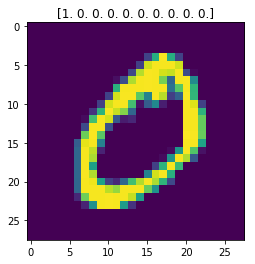

In [57]:
test_n = 0
plt.title(batch_label[test_n])
plt.imshow(batch_image[test_n, :, :, 0])
plt.show()

### 방법.2 - 이미지 한장씩 batch size 만큼 붙여가는 방법

In [58]:
for n, path in enumerate(data_list[:batch_size]):
    image = read_image(path)
    label = onehot_encode_label(path)
    
    # 맨 처음에만 image를 그대로 batch_image로 선언 해주고, 
    # 후에는 concatenate로 겹쳐준다. 
    if n == 0:
        batch_image = np.array([image])  # 그냥 image는 (28, 28, 1) 의 모양을 가지고 있기 때문에
        batch_label = np.array([label])  # (1, 28, 28, 1)의 새로운 차원을 얻기 위해 np.array([])를 씌운다.
    else:
        batch_image = np.concatenate((batch_image, [image]))
        batch_label = np.concatenate((batch_label, [label]))
    
    # C와의 차이점은 batch_image는 for문이 끝나고서도 메모리가 안 없어진다. 

In [60]:
image.shape, np.array([image]).shape

((28, 28, 1), (1, 28, 28, 1))

In [61]:
batch_image.shape, batch_label.shape

((64, 28, 28, 1), (64, 10))

## Generate Batch Data

1. data_list에서 맨 처음에 batch_size 만큼 batch_data를 가져온다. 
2. 그 다음부터 step 마다 전 step의 batch 다음의 batch 가져와야 한다. 

예로 step이 0일 때는 slice 0 부터 31까지 가져와야 한다.  
그 다음 step이 1 일 때는 slice 32부터 63까지 가져와야 한다. 

In [25]:
batch_per_epoch = batch_size // len(data_list)

# for epoch in range(epoch_n):
#     np.random.shuffle(data_list)
    
#     for step in range(batch_per_epoch):
#         batch_image = data_list[step * batch_size : (step + 1) * batch_size]
#         sess.run(train_op, feed_dict={input_image: batch_image})

# Generate batch data with tf.data

https://www.tensorflow.org/programmers_guide/datasets

In [62]:
import tensorflow as tf

C:\Users\blue_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [63]:
def _read_py_function(path, label):
    image = read_image(path)
    label = np.array(label, dtype=np.uint8)
    return image.astype(np.int32), label

def _resize_function(image_decoded, label):
    image_decoded.set_shape([None, None, None])
    image_resized = tf.image.resize_images(image_decoded, [28, 28])
    return image_resized, label

In [64]:
# label을 array 통채로 넣는게 아니고, list 화 시켜서 하나씩 넣기 위해 list로 바꿔주었다. 
label_list = [onehot_encode_label(path).tolist() for path in data_list]

In [72]:
data_list[0], label_list[0]

('data\\mnist_png\\training\\0\\1.png', [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [70]:
dataset = tf.data.Dataset.from_tensor_slices((data_list, label_list))
dataset = dataset.map(
    lambda data_list, label_list: tuple(tf.py_func(_read_py_function, [data_list, label_list], [tf.int32, tf.uint8])))

<TensorSliceDataset shapes: ((), (10,)), types: (tf.string, tf.int32)>

In [76]:
dataset = tf.data.Dataset.from_tensor_slices((data_list, label_list))
dataset = dataset.map(
    lambda data_list, label_list: tuple(tf.py_func(_read_py_function, [data_list, label_list], [tf.int32, tf.uint8])))

# 만약 tfrecords를 불러오는 경우
# dataset = tf.data.TFRecordDataset(data_list)

# Transform 방법들을 넣을 수 있다. (resize, crop)
dataset = dataset.map(_resize_function)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=(int(len(data_list) * 0.4) + 3 * batch_size))
dataset = dataset.batch(batch_size)

In [77]:
iterator = dataset.make_initializable_iterator()
image_stacked, label_stacked = iterator.get_next()

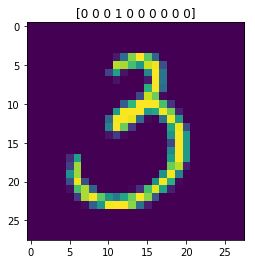

In [78]:
# next_element = iterator.get_next()

with tf.Session() as sess:
    sess.run(iterator.initializer)
    
    image, label = sess.run([image_stacked, label_stacked])

plt.title(label[0])
plt.imshow(image[0, :, :, 0])
plt.show()

In [80]:
image_stacked

<tf.Tensor 'IteratorGetNext_1:0' shape=(?, 28, 28, ?) dtype=float32>

In [79]:
image.shape, label.shape

((64, 28, 28, 1), (64, 10))